# Numerical Methods in Economics: Chapter 4

### Topics:
1. [One-Dimensional Minimization](#OneDimensionalMinimization) 

The general problem that we are trying to answer is how to minimize a given function subject to a set equality and inequality constraints:

$$
\begin{align}
\min_{x}\;&f(x) \\ 
\text{s.t. }&g_i(x) = 0, \; i = 1...n \\
&h_j(x) \leq 0, \; j = 1...n
\end{align}
$$

where, $f:\; \mathbb{R}^{n}\rightarrow\mathbb{R}$ is our objective Function,the functions $g_i(x):\mathbb{R}^{n}\rightarrow\mathbb{R}$ are our equality constraints, and the $h_j(x):\mathbb{R}^{n}\rightarrow\mathbb{R}$ are our inequality constraints. An example of this sort of problem would be maximizing utility with bugdet constraints, optimizing the [sharpe ratio](https://www.investopedia.com/terms/s/sharperatio.asp) of a portfolio of assets subject to constraints on the weights of our assets, or finding optimizal parameters for an econometric model. 

This Notebook will first examine and impliment various algorithms used in solving these problems. We will start with comparison methods, which require very little constraints on the functions we are optiming, but come at the cost of relatively slower convergence. We will then move to Gradient methods which differentiability of our objective and constraints. Finally we will look at methods that utilize curvature information, which while generaly converging the fastest of our three methods, will usually have the highest computational and memory costs.   

<a id = "OneDimensionalMinimization"></a>

<h3>One-Dimensional Minimization</h3>

The first optimization we will deal with is the scalar unconstrained problem given by $\min_{x}f(x)$, where $f: \mathbb{R}\rightarrow \mathbb{R}$. We start with this type of problem as to develop intuition into the methods in a cleara fasion. Furthermore, these methods later become the ingridients to larger multivariate algorithms.

Methods:

- <a href = "#Bracketing">Bracketing Method</a>
- <a href = "#Secant">Secant Method</a>
- <a href = "#Decker">Deckers Method</a>
- <a href = "#Brent">Brents Method</a>
- <a href = "#Newton">Newtons Method</a>


<h6><a id = 'Bracketing' href = https://en.wikipedia.org/wiki/Bisection_method >The Bisection or Bracketing Method</a></h6>

Suppose that we have a function, f, an that we have found points $a$, $b$, and $c$, such that $a<b<c$, and that $f(a), f(c) > f(b)$. Then this implies that somewhere in the region of $[a, c]$ there is a local minimum. We then want to find a smaller interval, say $[d, c]$ that also contains this local minimum. This new point $d$, will be in the region $(a, c)$. First, let us consider the case where $d \in (a,b]$, then if $f(d) > f(b)$, we know that the minimum must be in the region $[d, c]$. Likewise, if $f(d) < f(b)$, we know that the minimum must be in the region $[a, b]$. We would do this same process for a point $d \in [b, c)$. If we were to repeat this process, finding smaller and smaller regions in which some minimum may lie.

Let us try and visualize this algorithm:

In [1]:
# Impliment a simple version of the algorithm. The below is an abbreviated version of the 
# code found in the file optimization.py. Note that we have excluded the doc string and type annotations.
def one_iteration_bracketing(f, a, b, c): 
    # First select our new point as either the mid point between (a, b) or (b, c)
    if b-a < c-b :
        d = (b + c) / 2
    else: 
        d = (a + b) / 2
    
    # Compute the value at the new point d. 
    f_d = f(d)
    
    # Finally select the new triple to return.
    if d < b:
        if f(b) < f(d):
            return (d, b, c)
        else:
            return (a, d, b)
    else:
        if f(b) < f(d):
            return (a, b, d)
        else:
            return (b, d, c)
        
def bracketing(f, triple, n_iter = 100, eps = 0): 
    # Simply call iterations of the function untill one of the conditions are reached.
    # Initialize the number of iterations to 0, and the error to 100.
    n = 0; 
    
    while n < n_iter:
        triple = one_iteration_bracketing(f, *triple)
        if triple[2] - triple[0] < eps:
            break
        n += 1
        
    return triple

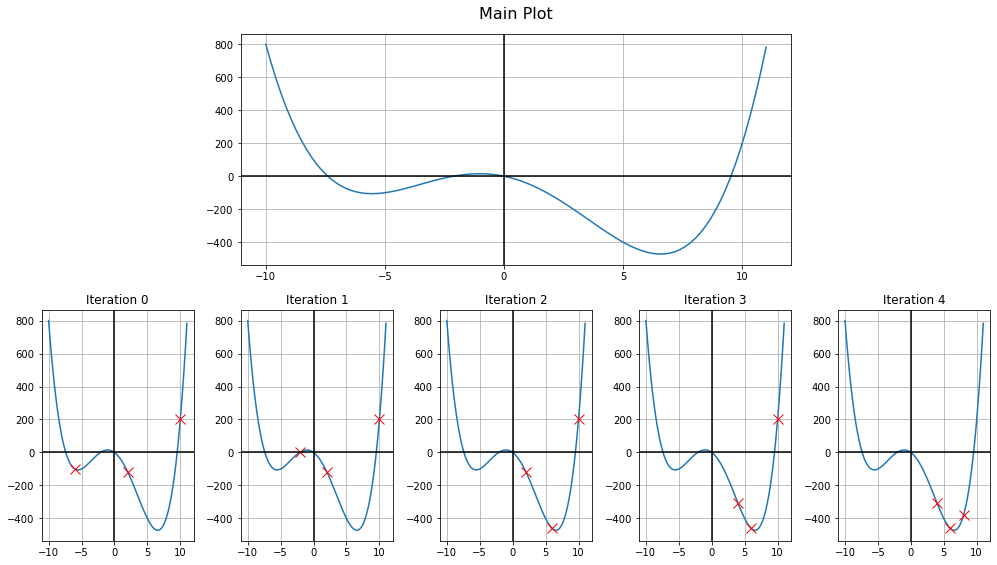

In [2]:
import matplotlib.pyplot as plt
import autograd.numpy as np

# Let us define an arbitray polynomial function. 
def poly(x: float) -> float:
    return x**4 / 5 - 15*x**2 - 30*x

poly_vec = np.vectorize(poly)

# Create a simple graph of our function
x = np.linspace(-10, 11, 100)
y = poly_vec(x)
start = (-6, 2, 10)

# Create Grid to visualize our function and ther first three iterations.
fig_1 = plt.figure(figsize = (14, 8))
grid_1 = fig_1.add_gridspec(2, 5, width_ratios = [1, 1, 1, 1, 1])

main = fig_1.add_subplot(grid_1[0, 1:4])
main.plot(x, y)
main.set_title(r"Main Plot", pad = 15, fontdict = dict(fontsize = 16))
plt.axhline(color='black')
plt.axvline(color='black')
plt.grid()

# Graph three iterations of the function.
for i in range(5):
    iter_i = fig_1.add_subplot(grid_1[1, i:i+1])
    iter_i.plot(x,y); 
    iter_i.plot(start, poly_vec(start), "rx", ms = 10)
    plt.axhline(color='black')
    plt.axvline(color='black')
    plt.grid()
    iter_i.set_title(f"Iteration {i}")
    start = one_iteration_bracketing(poly, *start)
    
plt.tight_layout(pad = 1.25)
plt.show();

We see that after each iteration the size of our bracketed interval $(a, c)$ decreases by half. If we consider our initial absolute error, $\epsilon_0 = c_0 - a_0$, and a desired level of precision $\epsilon$, then we can easily find the run time of our algorithm,

$$
\begin{align*}
\epsilon_n = |c_n - a_n| = \dfrac{|c_0 - a_0|}{2^n} \leq \epsilon \quad&\Longrightarrow\quad
\dfrac{|c_0 - a_0|}{\epsilon} \leq 2^n  \\
\ln_2\left(\dfrac{|c_0 - a_0|}{\epsilon}\right) \leq n \quad&\Longrightarrow\quad \dfrac{\ln{\left(|c_0 - a_0|\right)} - \ln{(\epsilon)}}{\ln(2)} \leq n. 
\end{align*}
$$

A further question might be how to establish the initial three points $(a, b, c)$. A standard way of doing this is to choose some initial point $x_0$, a step size $\Delta$, and a constant $\alpha > 1$, and computing $f(x_0), \; f(x_0\,\pm\,\alpha\Delta), f(x_0\,\pm\,\alpha^2\Delta) ... $, until we find a satisfying triple. There is an implimentation of this method found in optimization.py. 

This simple comparison based method is relatively slow (our error decreases linearly: $\epsilon_n = constant * \epsilon_{n-1}$), but it makes almost no requirements of the function in question, and this method will work on almost any continuous, bounded function on a finite interval. A major drawback of this method, and of many other optimization methods, is that the minimum that the algorithm finds is only guarenteed to be a local minimum, and that the minimum found is determined by its initial points. We can see this by taking two sets of similar initial points and seeing if they both find the global minimum of the function defined above.

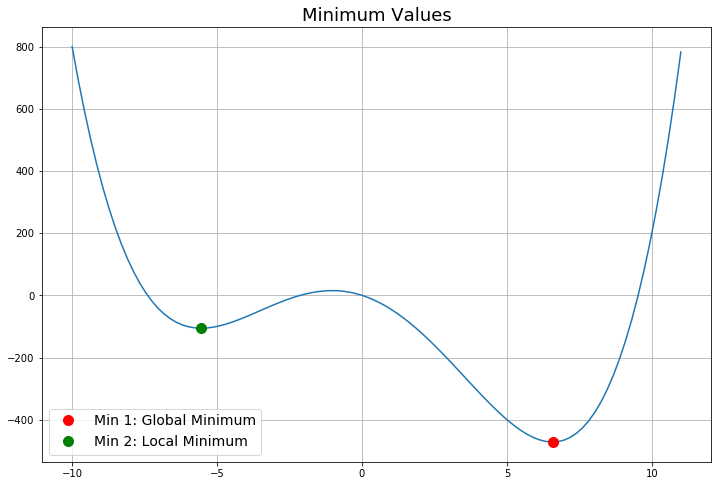

In [3]:
# Note that both of these brackets contain both minimums
init_1 = (-6, 2, 10)
init_2 = (-8, 0, 8)
x = np.linspace(-10, 11, 100)
y = poly_vec(x)

min_1 = bracketing(poly, init_1, eps = .01)
min_2 = bracketing(poly, init_2, eps = .01)

min_1 = (min_1[2] + min_1[0]) / 2
min_2 = (min_2[2] + min_2[0]) / 2

plt.figure(figsize = (12, 8))
plt.plot(x, y)
plt.plot(min_1, poly(min_1), "ro", label = "Min 1: Global Minimum", ms = 10)
plt.plot(min_2, poly(min_2), "go", label = "Min 2: Local Minimum", ms = 10)
plt.title("Minimum Values", fontdict = dict(fontsize = 18))
plt.legend(prop={'size': 14})

plt.grid()
plt.show()

We can see how sensitive the method is to changes in initial conditions. While both initial ranges contain the global minimum for our function, only one of them converges to the global minimum. Further, it only took a slight shift in our initial data for us to converge to a local minimum rather than a global minimum. 

<a id  = "Secant"></a>
<h3> Secant Method </h3>

<a id = Decker></a>
<h3> Deckers Method </h3>

<a  id = "Brent"></a>
<h3> Brents Method </h3>

### <a id = "Newton" href = https://en.wikipedia.org/wiki/Newton%27s_method>Newtons Method (Newton–Raphson method)</a>

Let us move to methods that require us to compute and utilize our functions derivative. Newtons method is also used to find the roots of differentiable functions on some given interval. In the case of root finding we only require that $f \in \mathbb{C}^1$. In the case of root finding, we start at some point $x_0$. We then derive the formula for the tangent line to our function at the point $x_0$, which is given by 

$$y = f'(x_0)(x - x_0) + f(x_0).$$

We then take for our new approximation the x-intercept of this function, which is given by

$$0 = f'(x_0)(x_1 - x_0) + f(x_0) \Longrightarrow x_1 = x_0 - \dfrac{f(x_0)}{f'(x_0)}.$$

This gives rise to the recurence relation that we use in Newtons method, $x_{n+1} = x_n - \dfrac{f(x_n)}{f'(x_n)}$. The convergence of this method can be shown using Taylor's Theorem, which states that any function $f(x)$ which has a continuous second derivative can be represented by an expansion about a point that is close to a root of $f(x)$. Suppose this root is $\alpha$, then the expansion of $f(\alpha)$ around a point $x_n$ is 

$$ f(\alpha) = f(x_n) + f'(x_n)(x_n - \alpha) + \frac{1}{2}f''(\xi)(\alpha - x_n)^2$$

where the term $\frac{1}{2}f''(\xi)(\alpha - x_n)^2$ is the Lagrange form for the [remainder term of our Taylor series expansion](https://en.wikipedia.org/wiki/Taylor%27s_theorem#Estimates_for_the_remainder), and the point $\xi$ is in between $\alpha$ and $x_n$. Since $f(\alpha)$ is our root, we can rewrite the above as,

$$
0 = f(x_n) + f'(x_n)(x_n - \alpha) + \frac{1}{2}f''(\xi)(\alpha - x_n)^2 \quad\Longrightarrow\quad \dfrac{f(x_n)}{f'(x_n)} + (x_n - \alpha) = \frac{-f''(\xi)}{2f'(x_n)}(\alpha - x_n)^2
$$

Here, if we use the equation $x_{n+1} = x_n - \dfrac{f(x_n)}{f'(x_n)}$, then we have our result,

$$
\underbrace{\alpha - x_{n+1}}_{\epsilon_{n+1}} = \frac{-f''(\xi)}{2f'(x_n)}(\underbrace{\alpha - x_n}_{\epsilon_{n}})^2 \quad\Longrightarrow\quad |\epsilon_{n+1}| = \left|\frac{f''(\xi)}{2f'(x_n)}\right|\epsilon_{n}^2.
$$
This shows that our algorithms rate of convergence is at least quadratic. For more detail on what conditions are required for this to hold, as for the litany of possible issues this algorithm faces I recomend digging into the wikipidea page linked above. 

Before we move onto the case of minimization, let us look at some code and visualizations of this algorithm as it pertains to root-finding. 

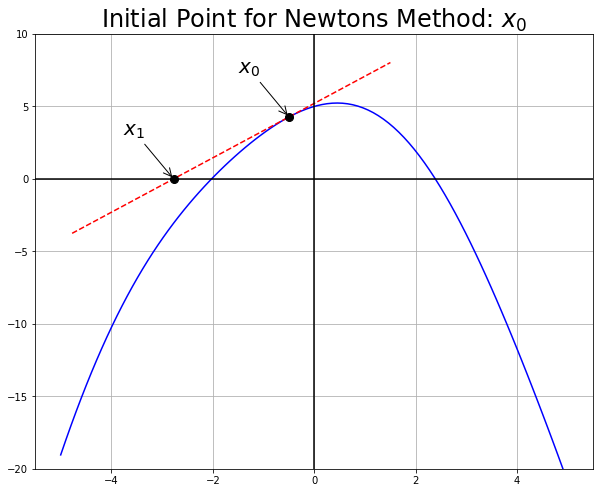

In [4]:
# To find the derivatives, we will use the package AutoGrad, a package that can 
# automatically differentiate native Python and Numpy code. It is an immensly useful package.
import autograd as ag

def f(x):
    return 5 + np.sin(x) - x**2 

# This will give the derivative of our function at a point x. Note that
# We have to pass float values to the function f_prime.
f_prime = ag.grad(f)

def tangent_line(x_i, x):
    return f_prime(x_i) * (x - x_i) + f(x_i)

x_0 = -0.5
x_1 = x_0 - f(x_0)/f_prime(x_0)

x = np.linspace(-5, 5, 100)
y = f(x)

x_tangent = np.linspace(x_0 - f(x_0)/f_prime(x_0) - 2, x_0 + 2, 20)
y_tangent = tangent_line(x_0, x_tangent)


plt.figure(figsize = (10, 8))
plt.ylim([-20, 10])
plt.plot(x, y, color = "blue")
plt.plot(x_tangent, y_tangent, 'r--')

plt.plot(x_0, f(x_0), c = "k", marker = 'o', ms = 8)
plt.annotate(r"$x_0$", [x_0, f(x_0)], [x_0 - 1, f(x_0) + 3],
            arrowprops = {"arrowstyle": "->"}, fontsize = 20)

plt.plot(x_1, 0, c = "k", marker = 'o', ms = 8)
plt.annotate(r"$x_1$", [x_1, 0], [x_1 - 1, 3],
            arrowprops = {"arrowstyle": "->"}, fontsize = 20)

plt.title(r"Initial Point for Newtons Method: $x_0$",
           fontdict = {"fontsize": 24})


plt.grid()
plt.axhline(color='black')
plt.axvline(color='black')
plt.show()

In [19]:
# The python file optimization that is found with this note book will need to be downloaded and placed in the same folder
# As the note book for the below to work.
from optimization import visualize_Newton
import plotly

Please feel free to try this out on other functions to see how the methods behavior changes. Cubic functions are of interest since they sometimes exhibit cyclic behavior. Note that you may need to install the needed packages and extensions to view and interact with the plots below, please see here for more help with this, [Getting Started with Plotly in Python](https://plot.ly/python/getting-started/). The graphs will sometimes take a moment to initially load. 

In [29]:
# Set first point to 0. N is the number of steps to visualize
x_i = -10
N = 5
x = np.linspace(-10, 10, 100)
y = f(x)

# This allows you to create the image and open it as an html file. The cell below
# allows you to view it in the notebook.
fig = visualize_Newton(x_i, N, f, f_prime)
plotly.offline.plot(fig, filename='interactive_graphs/NewtonsMethod_1.html', include_mathjax = 'cdn');

In [35]:
def tanh(x):
    return np.tanh(x)

def cubic(x):
    return (x**3 - 2*x + 3) 

tanh_p = ag.grad(tanh)
cubic_p = ag.grad(cubic)



# Both of the functions above exhibit interesting behavior. If you begin at x = 1, then the Cubic function enters
# a cycle alternating between x = 0 and x = 1. Meanwhile, we can see that for the hyper bolic tangent,  
visualize_Newton(-1.1, 5, tanh, tanh_p, xlim = [-5,5], ylim = [-2, 2])

Let us now approach the problem from the perspective of optimization. Note that since we are now trying to minimize the function, rather than find its roots, we need to make different requirements of the function. Here, we will require that our function $f(x)$ is twice diferentiable. 

The core idea is that for some point $x_n$, we can use Taylors theorom to approximate our function $f(x)$ with a second degree polynomial, $p(x)$, 

$$ p(x) = f(x_n) + f'(x_n)(x-x_n) + \dfrac{f''(x_n)(x-x_n)^2}{2}.$$ 

Our approximation for the minimum of $f(x)$ would then be given by the minimizing value for our polynomial $p(x)$, which is given by,

$$
p'(x) = f'(x_n) + f''(x_n)(x-x_n) = 0 \quad\Longrightarrow\quad x = x_n - \dfrac{f'(x_n)}{f''(x_n)}.
$$

Therefore, our approximation has a critical point at $x_{n+1} = x_n - \dfrac{f'(x_n)}{f''(x_n)}$. We can see that the update rule we have derived is the application of Newtons method to the derivative of our function, and in essence we are searching for the roots of our functions derivatives, where either a  local minimum or maximum will occur. It is important to note that we only know that the point we found is a critical point, and so we must check that $f''(x) > 0$ to say that the point is possibely near a minimum.

#### Theorem: 
Suppose $f(x)$ is minimized at a point $x^*$, that $f(x) \in C^3$ in a region around the point $x^*$, and that $f''(x^*) \ne 0$. Then $\exists \epsilon > 0$ such that if $|x_0 - x^*| < 0$, then the sequence of $x_n$ defined above will converge quadratically to $x^*$. In particular,

$$
\tag{1}\lim_{n\to\infty}{\dfrac{|x_{n+1}-x^*|}{|x_{n}-x^*|^2}} = \left|\dfrac{f'''(x^*)}{2f''(x^*)}\right|
$$

is the quadratic rate of convergence.

#### Proof:
Since we have that our function $f$ is $C^3$, $f'(x^*) = 0 \ne f''(x^*)$, and that $f'$ is $C^2$, then Taylors theorem gives that

$$
f'(x) = f'(x_n) + f''(x_n)(x-x_n)+\frac{1}{2}f'''(\eta_n)(x-x_n)^2
$$

for some $\eta_n \in [x_n, x] \cup [x, x_n]$. If we take this expansion at the point $x = x^*$, then

$$
\begin{align}
0 &= f'(x_n) + f''(x_n)(x^*-x_n)+\frac{1}{2}f'''(\eta_n)(x^*-x_n)^2 \\
\left(x_n - \dfrac{f'(x_n)}{f''(x_n)}\right) - x^* &=  \frac{f'''(\eta_n)}{2f''(x_n)}(x^*-x_n)^2 \\
\tag{2}|x_{n+1} - x^*| &= \left|\frac{f'''(\eta_n)}{2f''(x_n)}\right|(x^*-x_n)^2.
\end{align}
$$

Therefore, for any $\beta \in (0,1)$, if $|x_m - x^*|$ is sufficiently small, then the above shows that $|x{n+1} - x^*| <\beta|x_n-x^*| \; \forall n > m$. This implies that $x_n \to x^*$, and our method will find a root. Finally, along some convergent sequence, equation 2 implies equation 1.

Similar to the above, lets try to visualize this method. We will use the utility maximization problem given in the textbook as a motivating example. Consider a consumer has $\$1$ to spend on two goods x and y, where the price of x is $\$2$, and the price of y is $\$3$, and his utility function is given by $u(x, y) = x^{\frac{1}{2}} + 2y^{\frac{1}{2}}$. Then this is really a univariate problem since we can substitute y for $1-x$. The problem is then,

$$
\max_{x} \left(\dfrac{x}{2}\right)^{\dfrac{1}{2}} + 2\left(\dfrac{1-x}{3}\right)^{\dfrac{1}{2}}. 
$$

Below we graph how each iteration of the method moves along both our objective function, and along the first derivative.

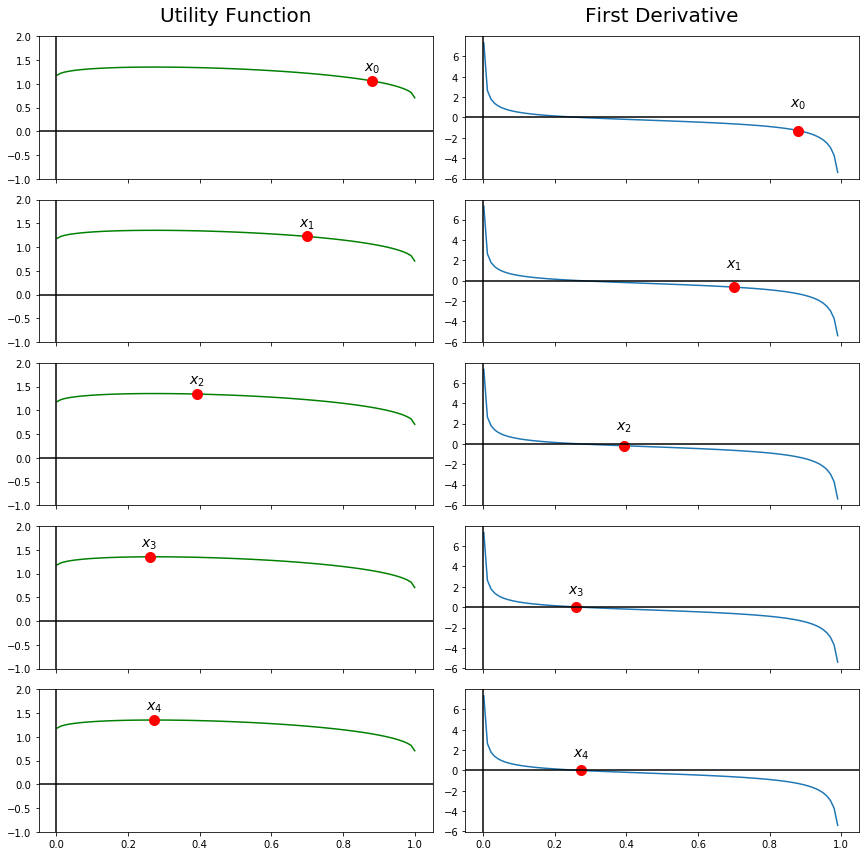

Newtons method yields the following sequence: 
x:             0.88       0.69983    0.39303    0.25965    0.27242    0.27273   
Utility:       1.06332    1.22417    1.34291    1.35386    1.35401    1.35401   
Derivative:    -1.28978   -0.63116   -0.17711   0.02284    0.00053    0.0       


In [94]:
def utility(x):
    return np.power(x/2, 0.5) + 2*np.power((1 - x)/3, 0.5)

utility_p = ag.elementwise_grad(utility)
utility_pp = ag.elementwise_grad(utility_p)

x = np.linspace(1, 500, 100)/500
y = utility(x)
y_p = utility_p(x)
y_pp = utility_pp(x)

n_iters = 5
x_0 = [0.88]

fig, axes = plt.subplots(nrows = n_iters, ncols = 2, sharex = True, figsize = (12, 12))
axes[0][0].set_title('Utility Function', pad = 15, fontdict = dict(fontsize = 20))
axes[0][1].set_title('First Derivative', pad = 15, fontdict = dict(fontsize = 20))


for i in range(n_iters):
    axes[i][0].plot(x, y, 'g')
    axes[i][0].set_ylim(-1, 2)
    axes[i][0].plot(x_0[-1], utility(x_0[-1]), "ro", ms = 10)
    axes[i][0].annotate(s = r"$x_{{{i}}}$".format(i = i),
                        xy = [x_0[-1], utility(x_0[-1])],
                        xytext=(0, 20), textcoords='offset pixels',
                        fontsize = 14,
                        horizontalalignment='center',
                        verticalalignment='top')
    axes[i][0].axhline(color='black'); axes[i][0].axvline(color='black')
    
    
    axes[i][1].plot(x, y_p)
    axes[i][1].plot(x_0[-1], utility_p(x_0[-1]), "ro", ms = 10)
    axes[i][1].annotate(s = r"$x_{{{i}}}$".format(i = i),
                        xy = [x_0[-1], utility(x_0[-1])],
                        xytext=(0, 10), textcoords='offset pixels',
                        fontsize = 14,
                        horizontalalignment='center',
                        verticalalignment='top')
    axes[i][1].axhline(color='black'); axes[i][1].axvline(color='black')
    
    x_0.append(x_0[-1] - utility_p(x_0[-1])/utility_pp(x_0[-1]))
    
fig.tight_layout()
plt.show()
print("Newtons method yields the following sequence: ")
print("{:<15}".format("x:") + " ".join([f"{round(x, 5): <10}" for x in x_0]))
print("{:<15}".format("Utility:") + " ".join([f"{round(utility(x), 5): <10}" for x in x_0]))
print("{:<15}".format("Derivative:") + " ".join([f"{round(utility_p(x), 5): <10}" for x in x_0]))